# Machine Learning Engineer Nanodegree Capstone Project

# Importing Dependencies

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import chi2, SelectKBest, RFE
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import time
%matplotlib notebook
%matplotlib inline

# Reading the Dataset

In [2]:
df = pd.read_csv('bank/bank-full.csv', sep= ';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [3]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,45211.0,40.936210,10.618762,18.0,33.0,39.0,48.0,95.0
balance,45211.0,1362.272058,3044.765829,-8019.0,72.0,448.0,1428.0,102127.0
day,45211.0,15.806419,8.322476,1.0,8.0,16.0,21.0,31.0
duration,45211.0,258.163080,257.527812,0.0,103.0,180.0,319.0,4918.0
campaign,45211.0,2.763841,3.098021,1.0,1.0,2.0,3.0,63.0
pdays,45211.0,40.197828,100.128746,-1.0,-1.0,-1.0,-1.0,871.0
previous,45211.0,0.580323,2.303441,0.0,0.0,0.0,0.0,275.0


# Feature Engineering

# Creating some categorical Attributes

In [4]:
df['bal_sign'] = pd.Series(df['balance'] > 0)

# Label Encoding the Binary Attributes

In [5]:
labels = ['housing', 'default', 'loan', 'y']
for label in labels:
    label_encoder = LabelEncoder()
    label_encoder.fit(df[label])
    df[label] = label_encoder.transform(df[label])

In [6]:
# Will be On-Hot Encoded Later
cols = ['job', 'contact', 'marital','education', 'poutcome', 'month', 'day']
for label in cols:
    label_encoder = LabelEncoder()
    label_encoder.fit(df[label])
    df[label] = label_encoder.transform(df[label])

# Exploratory Visualization

Ratio of classes (no : yes) 0.883015195417 : 0.116984804583


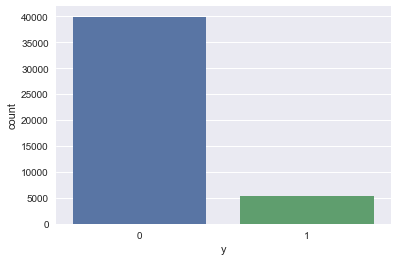

In [7]:
ratio = df.y[df.y == 1].count() / df.y.shape[0]
print('Ratio of classes (no : yes)', 1- ratio, ':', ratio)
sns.countplot(df.y)
plt.show()

In [8]:
df_corr = df.corr()

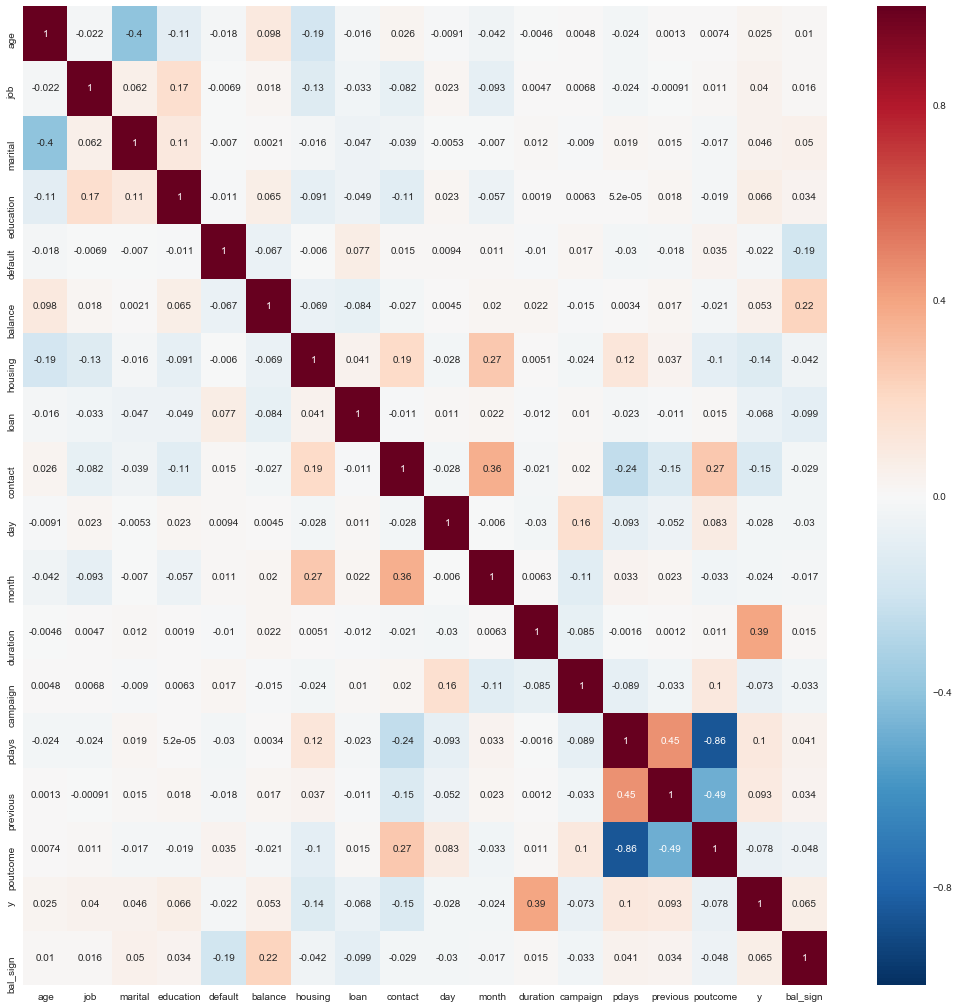

In [9]:
plt.figure(figsize=(18, 18))
sns.heatmap(df_corr, annot = True)
plt.show()

- From the above plot we can observe that most of the features are independent of each other.
- Feature-pair (pdays - previous) is highly negatively correlated.
- Therefore we can remove "pdays"

In [10]:
final_df = df.drop(["pdays"], axis = 1)

In [11]:
df_corr = final_df.corr()

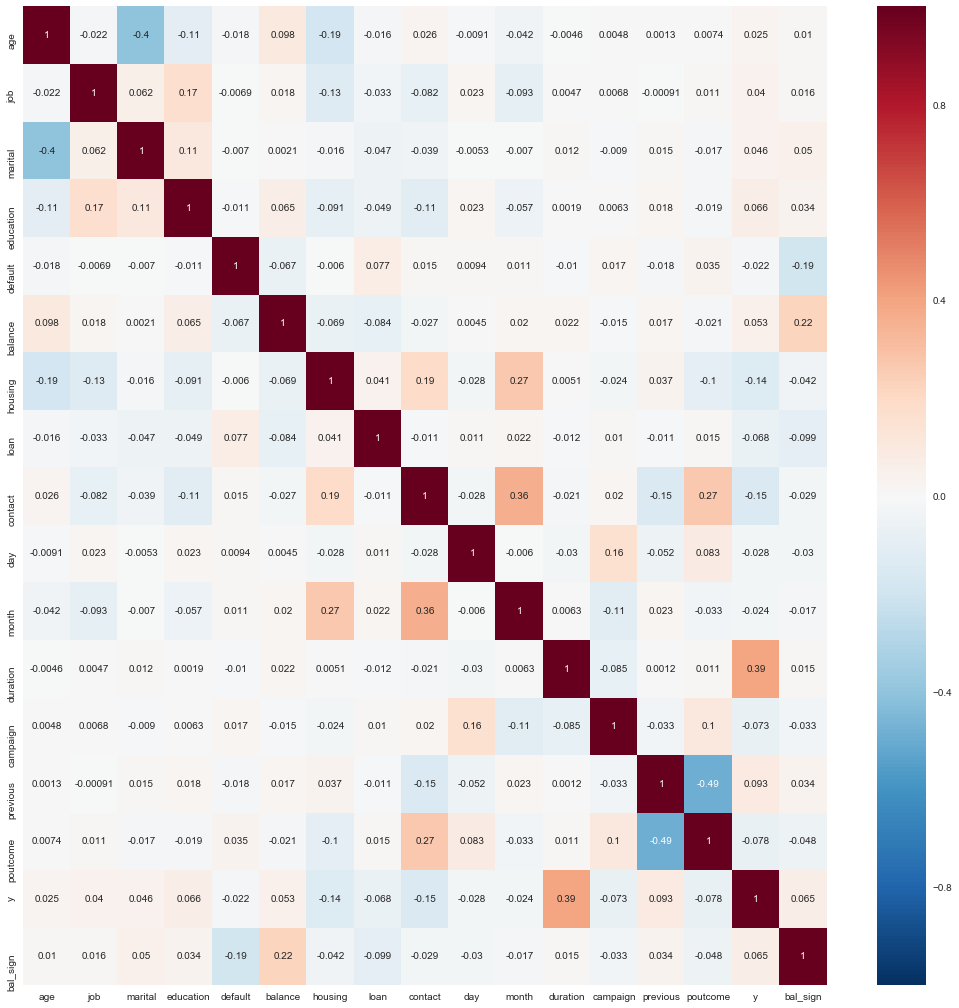

In [12]:
plt.figure(figsize=(18, 18))
sns.heatmap(df_corr, annot = True)
plt.show()

In [13]:
df = pd.get_dummies(df, columns = cols)

In [14]:
df.head()

,age,default,balance,housing,loan,duration,campaign,pdays,previous,y,...,day_21,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30
0,58,0,2143,1,0,261,1,-1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,44,0,29,1,0,151,1,-1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,33,0,2,1,1,76,1,-1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,47,0,1506,1,0,92,1,-1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,33,0,1,0,0,198,1,-1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,45211.0,40.936210,10.618762,18.0,33.0,39.0,48.0,95.0
default,45211.0,0.018027,0.133049,0.0,0.0,0.0,0.0,1.0
balance,45211.0,1362.272058,3044.765829,-8019.0,72.0,448.0,1428.0,102127.0
housing,45211.0,0.555838,0.496878,0.0,0.0,1.0,1.0,1.0
loan,45211.0,0.160226,0.366820,0.0,0.0,0.0,0.0,1.0
duration,45211.0,258.163080,257.527812,0.0,103.0,180.0,319.0,4918.0
campaign,45211.0,2.763841,3.098021,1.0,1.0,2.0,3.0,63.0
pdays,45211.0,40.197828,100.128746,-1.0,-1.0,-1.0,-1.0,871.0
previous,45211.0,0.580323,2.303441,0.0,0.0,0.0,0.0,275.0
y,45211.0,0.116985,0.321406,0.0,0.0,0.0,0.0,1.0


# Normalizing the Features

In [16]:
labels = df.y
scaler = MinMaxScaler()
features = pd.DataFrame(scaler.fit_transform(df.drop(['y'], axis = 1)), columns = df.drop(['y'], axis = 1).columns)

In [17]:
features.head()

,age,default,balance,housing,loan,duration,campaign,pdays,previous,bal_sign,...,day_21,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30
0,0.519481,0.0,0.092259,1.0,0.0,0.053070,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.337662,0.0,0.073067,1.0,0.0,0.030704,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.194805,0.0,0.072822,1.0,1.0,0.015453,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.376623,0.0,0.086476,1.0,0.0,0.018707,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.194805,0.0,0.072812,0.0,0.0,0.040260,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Splitting Data into Training and Testing data

In [18]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=1, stratify = labels)

In [18]:
cv = StratifiedKFold(n_splits = 5, shuffle=True, random_state = 1)

In [19]:
# DataFrame to store results
testing = pd.DataFrame(columns = ["Classifier", "F1-Score", "AUC", "Accuracy"])

# Logistic Regression

In [20]:
params = [
            {
                "penalty" : ['l2'], 
                "C" : [0.01, 0.1, 1.0, 10.0], 
                "solver" : ["sag"], 
                "max_iter" : [100, 200]
            },
            {
                "penalty" : ['l1'], 
                "C" : [0.01, 0.1, 1.0, 10.0], 
                "solver" : ["saga"], 
                "max_iter" : [100, 200]
            }
]
clf = GridSearchCV(estimator = LogisticRegression(n_jobs = -1, class_weight = "balanced"), param_grid = params, cv = cv, 
                   n_jobs = -1, scoring = "f1")
clf.fit(X_train, y_train)

C:\Python35\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'solver': ['sag'], 'penalty': ['l2'], 'max_iter': [100, 200], 'C': [0.01, 0.1, 1.0, 10.0]}, {'solver': ['saga'], 'penalty': ['l1'], 'max_iter': [100, 200], 'C': [0.01, 0.1, 1.0, 10.0]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [21]:
clf.best_params_

{'C': 1.0, 'max_iter': 200, 'penalty': 'l2', 'solver': 'sag'}

In [23]:
clf.best_score_

0.55991615538320283

In [28]:
f1 = f1_score(y_test, clf.predict(X_test))
auc = roc_auc_score(y_test, clf.predict(X_test))
acc = accuracy_score(y_test, clf.predict(X_test))

print("F1-Score on test data is : %0.3f" %f1)
print("Area under ROC on test data is : %0.3f" %auc)
print("Accuracy on test data is : %0.3f" %acc)

testing.loc[-1] = ["Logistic Regression", f1, auc, acc]
testing.index = testing.index + 1
testing = testing.sort_index()

F1-Score on test data is : 0.548
Area under ROC on test data is : 0.822
Accuracy on test data is : 0.848


# Decision Tree Classifier

In [29]:
params = {
            "criterion" : ["gini", "entropy"], 
            "splitter" : ["best", "random"], 
            "max_depth" : [25, 50, 75, None],
            "min_samples_split" : [3, 6], 
            "min_samples_leaf" : [2, 4],  
        }
clf = GridSearchCV(estimator = DecisionTreeClassifier(class_weight = "balanced", presort = True), param_grid = params, cv = cv, 
                   n_jobs = -1, scoring = "f1")
clf.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
       error_score='raise',
       estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=True, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'splitter': ['best', 'random'], 'max_depth': [25, 50, 75], 'min_samples_split': [3, 6], 'min_samples_leaf': [2, 4], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [30]:
clf.best_params_

{'criterion': 'entropy',
 'max_depth': 75,
 'min_samples_leaf': 4,
 'min_samples_split': 6,
 'splitter': 'random'}

In [31]:
clf.best_score_

0.53008297291174689

In [32]:
f1 = f1_score(y_test, clf.predict(X_test))
auc = roc_auc_score(y_test, clf.predict(X_test))
acc = accuracy_score(y_test, clf.predict(X_test))

print("F1-Score on test data is : %0.3f" %f1)
print("Area under ROC on test data is : %0.3f" %auc)
print("Accuracy on test data is : %0.3f" %acc)

testing.loc[-1] = ["Decision Tree", f1, auc, acc]
testing.index = testing.index + 1
testing = testing.sort_index()

F1-Score on test data is : 0.526
Area under ROC on test data is : 0.804
Accuracy on test data is : 0.841


# Random Forest Classifier

In [33]:
params = {
            "n_estimators" : [100, 200], 
            "criterion" : ["gini", "entropy"], 
            "max_depth" : [25, 50, 75],
            "min_samples_split" : [3, 6], 
            "min_samples_leaf" : [2, 4]}
clf = GridSearchCV(estimator = RandomForestClassifier(class_weight = "balanced", n_jobs = -1), param_grid = params, cv = cv, n_jobs = -1, scoring = "f1")
clf.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'min_samples_leaf': [2, 4], 'n_estimators': [100, 200], 'min_samples_split': [3, 6], 'max_depth': [25, 50, 75], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [34]:
f1_score(y_test, clf.predict(X_test))

0.61168639053254437

In [35]:
clf.best_params_

{'criterion': 'entropy',
 'max_depth': 50,
 'min_samples_leaf': 4,
 'min_samples_split': 3,
 'n_estimators': 200}

In [36]:
clf.best_score_

0.61407331786148134

In [37]:
f1 = f1_score(y_test, clf.predict(X_test))
auc = roc_auc_score(y_test, clf.predict(X_test))
acc = accuracy_score(y_test, clf.predict(X_test))

print("F1-Score on test data is : %0.3f" %f1)
print("Area under ROC on test data is : %0.3f" %auc)
print("Accuracy on test data is : %0.3f" %acc)

testing.loc[-1] = ["Random Forest", f1, auc, acc]
testing.index = testing.index + 1
testing = testing.sort_index()

F1-Score on test data is : 0.612
Area under ROC on test data is : 0.840
Accuracy on test data is : 0.884


# AdaBoost Classifier

In [38]:
params = {
            "base_estimator": [DecisionTreeClassifier(class_weight = "balanced"), 
                               LogisticRegression(n_jobs = -1, class_weight = 'balanced', penalty = 'l2', solver = 'sag')], 
            "n_estimators" : [500, 1000], 
            "learning_rate" : [0.01, 0.1, 1.0]
        }
clf = GridSearchCV(estimator = AdaBoostClassifier(), param_grid = params, cv = cv, n_jobs = -1, scoring = "f1")
clf.fit(X_train, y_train)

C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs

C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs

C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs

C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs

C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs

C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs

C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs

C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs

C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs

C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs

C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs

C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs

C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs

C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs

C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs

C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs

C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs

C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs

C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs

C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs

C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs

C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs

C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs

C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs

C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
       error_score='raise',
       estimator=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [100, 500, 1000], 'base_estimator': [DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_s...ver='liblinear', tol=0.0001, verbose=0, warm_start=False)], 'learning_rate': [0.01, 0.1, 1.0, 10.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [39]:
clf.best_params_

{'base_estimator': LogisticRegression(C=1.0, class_weight='balanced', dual=False,
           fit_intercept=True, intercept_scaling=1, max_iter=100,
           multi_class='ovr', n_jobs=-1, penalty='l2', random_state=None,
           solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
 'learning_rate': 1.0,
 'n_estimators': 1000}

In [40]:
clf.best_score_

0.54405191467819236

In [41]:
f1 = f1_score(y_test, clf.predict(X_test))
auc = roc_auc_score(y_test, clf.predict(X_test))
acc = accuracy_score(y_test, clf.predict(X_test))

print("F1-Score on test data is : %0.3f" %f1)
print("Area under ROC on test data is : %0.3f" %auc)
print("Accuracy on test data is : %0.3f" %acc)

testing.loc[-1] = ["AdaBoost", f1, auc, acc]
testing.index = testing.index + 1
testing = testing.sort_index()

F1-Score on test data is : 0.541
Area under ROC on test data is : 0.810
Accuracy on test data is : 0.849


# Gaussian Naive Bayes

In [43]:
params = {}
clf = GridSearchCV(estimator = GaussianNB(), param_grid = params, cv = cv, n_jobs = -1, scoring = "f1")
clf.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
       error_score='raise', estimator=GaussianNB(priors=None),
       fit_params=None, iid=True, n_jobs=-1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [45]:
clf.best_score_

0.43371025312878381

In [46]:
f1 = f1_score(y_test, clf.predict(X_test))
auc = roc_auc_score(y_test, clf.predict(X_test))
acc = accuracy_score(y_test, clf.predict(X_test))

print("F1-Score on test data is : %0.3f" %f1)
print("Area under ROC on test data is : %0.3f" %auc)
print("Accuracy on test data is : %0.3f" %acc)

testing.loc[-1] = ["Gaussian Naive Bayes", f1, auc, acc]
testing.index = testing.index + 1
testing = testing.sort_index()

F1-Score on test data is : 0.415
Area under ROC on test data is : 0.696
Accuracy on test data is : 0.826


# Multinomial Naive Bayes

In [47]:
params = {
            "alpha" : [0.0, 0.1, 0.5, 1.0], 
            "fit_prior" : [True, False]
         }
clf = GridSearchCV(estimator = MultinomialNB(), param_grid = params, cv = cv, n_jobs = -1, scoring = "f1")
clf.fit(X_train, y_train)

C:\Python35\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
       error_score='raise',
       estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'fit_prior': [True, False], 'alpha': [0.0, 0.1, 0.5, 1.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [48]:
clf.best_params_

{'alpha': 0.0, 'fit_prior': True}

In [49]:
clf.best_score_

0.37920155301286462

In [50]:
f1 = f1_score(y_test, clf.predict(X_test))
auc = roc_auc_score(y_test, clf.predict(X_test))
acc = accuracy_score(y_test, clf.predict(X_test))

print("F1-Score on test data is : %0.3f" %f1)
print("Area under ROC on test data is : %0.3f" %auc)
print("Accuracy on test data is : %0.3f" %acc)

testing.loc[-1] = ["Multinomial Naive Bayes", f1, auc, acc]
testing.index = testing.index + 1
testing = testing.sort_index()

F1-Score on test data is : 0.371
Area under ROC on test data is : 0.627
Accuracy on test data is : 0.886


# Multi Layer Perceptron

In [51]:
params = [
            {
                "hidden_layer_sizes" : [(50, ), (50, 50), (50, 50, 50)],
                "solver" : ["adam", "lbfgs"], 
                "alpha" : [0.0001, 0.001], 
                "max_iter" : [100, 200]
            },
            {
                "hidden_layer_sizes" : [(50, ), (50, 50), (50, 50, 50)],
                "solver" : ["sgd"], 
                "alpha" : [0.0001, 0.001], 
                "learning_rate" : ["constant", "invscaling", "adaptive"], 
                "max_iter" : [100, 200]
            }
]
clf = GridSearchCV(estimator = MLPClassifier(early_stopping = True, activation = "relu"), param_grid = params, cv = cv, 
                   n_jobs = -1, scoring = "f1")
clf.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
       error_score='raise',
       estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'solver': ['adam', 'lbfgs'], 'alpha': [0.0001, 0.001], 'max_iter': [100, 200], 'hidden_layer_sizes': [(50,), (50, 50), (50, 50, 50)]}, {'solver': ['sgd'], 'alpha': [0.0001, 0.001], 'max_iter': [100, 200], 'learning_rate': ['constant', 'invscaling', 'adaptive'], 'hidden_layer_sizes': [(50,), (50, 50), (50, 50, 50)]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score

In [52]:
clf.best_params_

{'alpha': 0.0001,
 'hidden_layer_sizes': (50, 50, 50),
 'max_iter': 100,
 'solver': 'lbfgs'}

In [53]:
clf.best_score_

0.55932854398089682

In [54]:
f1 = f1_score(y_test, clf.predict(X_test))
auc = roc_auc_score(y_test, clf.predict(X_test))
acc = accuracy_score(y_test, clf.predict(X_test))

print("F1-Score on test data is : %0.3f" %f1)
print("Area under ROC on test data is : %0.3f" %auc)
print("Accuracy on test data is : %0.3f" %acc)

testing.loc[-1] = ["Multi Layer Perceptron", f1, auc, acc]
testing.index = testing.index + 1
testing = testing.sort_index()

F1-Score on test data is : 0.542
Area under ROC on test data is : 0.726
Accuracy on test data is : 0.902


# Support Vector Machine

In [55]:
params = [
            {"C" : [0.01, 0.1, 1.0], "kernel" : ["poly"],
              "degree" : [2, 3, 4],
              "gamma" : [0.001, "auto", 0.1]
            },
            {"C" : [0.01, 0.1, 1.0], "kernel" : ["rbf", "sigmoid"], 
              "gamma" : [0.001, "auto", 0.1]},
            {"C" : [0.01, 0.1, 1.0], "kernel" : ["linear"]}
        ]
clf = GridSearchCV(estimator = SVC(class_weight = "balanced", max_iter = 10000, verbose = True), param_grid = params, 
                   cv = cv, n_jobs = -1, scoring = "f1", verbose = 2)
clf.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 19.3min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 107.9min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed: 173.8min finished


[LibSVM]

C:\Python35\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
       error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=10000, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=True),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'kernel': ['poly'], 'C': [0.01, 0.1, 1.0], 'gamma': [0.001, 'auto', 0.1], 'degree': [2, 3, 4]}, {'kernel': ['rbf', 'sigmoid'], 'C': [0.01, 0.1, 1.0], 'gamma': [0.001, 'auto', 0.1]}, {'kernel': ['linear'], 'C': [0.01, 0.1, 1.0]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=2)

In [56]:
clf.best_params_

{'C': 1.0, 'gamma': 0.1, 'kernel': 'rbf'}

In [57]:
clf.best_score_

0.50743487797588727

In [58]:
f1 = f1_score(y_test, clf.predict(X_test))
auc = roc_auc_score(y_test, clf.predict(X_test))
acc = accuracy_score(y_test, clf.predict(X_test))

print("F1-Score on test data is : %0.3f" %f1)
print("Area under ROC on test data is : %0.3f" %auc)
print("Accuracy on test data is : %0.3f" %acc)

testing.loc[-1] = ["Support Vector Machine", f1, auc, acc]
testing.index = testing.index + 1
testing = testing.sort_index()

F1-Score on test data is : 0.342
Area under ROC on test data is : 0.742
Accuracy on test data is : 0.560


In [61]:
testing

,Classifier,F1-Score,AUC,Accuracy
0,Support Vector Machine,0.342310,0.741701,0.559770
1,Multi Layer Perceptron,0.541710,0.726165,0.901581
2,Multinomial Naive Bayes,0.371272,0.626607,0.885768
3,Gaussian Naive Bayes,0.414771,0.695947,0.826496
4,AdaBoost,0.540868,0.810394,0.849055
5,Random Forest,0.611686,0.839548,0.883888
6,Decision Tree,0.526454,0.804405,0.840650
7,Logistic Regression,0.547721,0.822227,0.847506


# Feature Selection

In [18]:
k_best_features = pd.DataFrame(SelectKBest(chi2, k=25).fit_transform(features, labels))

In [19]:
cv = StratifiedKFold(n_splits = 5, shuffle=True, random_state = 1)

In [20]:
# DataFrame to store results
testing = pd.DataFrame(columns = ["Classifier", "F1-Score", "AUC", "Accuracy"])

In [21]:
X_train, X_test, y_train, y_test = train_test_split(k_best_features, labels, test_size=0.2, random_state=1, stratify = labels)

# Logistic Regression

In [22]:
params = [
            {
                "penalty" : ['l2'], 
                "C" : [0.01, 0.1, 1.0, 10.0], 
                "solver" : ["sag"], 
                "max_iter" : [100, 200]
            },
            {
                "penalty" : ['l1'], 
                "C" : [0.01, 0.1, 1.0, 10.0], 
                "solver" : ["saga"], 
                "max_iter" : [100, 200]
            }
]
clf = GridSearchCV(estimator = LogisticRegression(n_jobs = -1, class_weight = "balanced"), param_grid = params, cv = cv, 
                   n_jobs = -1, scoring = "f1")
clf.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'max_iter': [100, 200], 'C': [0.01, 0.1, 1.0, 10.0], 'penalty': ['l2'], 'solver': ['sag']}, {'max_iter': [100, 200], 'C': [0.01, 0.1, 1.0, 10.0], 'penalty': ['l1'], 'solver': ['saga']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [23]:
clf.best_params_

{'C': 1.0, 'max_iter': 200, 'penalty': 'l2', 'solver': 'sag'}

In [24]:
clf.best_score_

0.54849549733983305

In [25]:
f1 = f1_score(y_test, clf.predict(X_test))
auc = roc_auc_score(y_test, clf.predict(X_test))
acc = accuracy_score(y_test, clf.predict(X_test))

print("F1-Score on test data is : %0.3f" %f1)
print("Area under ROC on test data is : %0.3f" %auc)
print("Accuracy on test data is : %0.3f" %acc)

testing.loc[-1] = ["Logistic Regression", f1, auc, acc]
testing.index = testing.index + 1
testing = testing.sort_index()

F1-Score on test data is : 0.543
Area under ROC on test data is : 0.824
Accuracy on test data is : 0.843


# Decision Tree Classifier

In [26]:
params = {
            "criterion" : ["gini", "entropy"], 
            "splitter" : ["best", "random"], 
            "max_depth" : [10, 15, 20, None],
            "min_samples_split" : [3, 6], 
            "min_samples_leaf" : [2, 4],  
        }
clf = GridSearchCV(estimator = DecisionTreeClassifier(class_weight = "balanced", presort = True), param_grid = params, cv = cv, 
                   n_jobs = -1, scoring = "f1")
clf.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
       error_score='raise',
       estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=True, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'min_samples_leaf': [2, 4], 'min_samples_split': [3, 6], 'splitter': ['best', 'random'], 'criterion': ['gini', 'entropy'], 'max_depth': [10, 15, 20, None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [27]:
clf.best_params_

{'criterion': 'entropy',
 'max_depth': 10,
 'min_samples_leaf': 4,
 'min_samples_split': 6,
 'splitter': 'random'}

In [28]:
clf.best_score_

0.52176047449465357

In [29]:
f1 = f1_score(y_test, clf.predict(X_test))
auc = roc_auc_score(y_test, clf.predict(X_test))
acc = accuracy_score(y_test, clf.predict(X_test))

print("F1-Score on test data is : %0.3f" %f1)
print("Area under ROC on test data is : %0.3f" %auc)
print("Accuracy on test data is : %0.3f" %acc)

testing.loc[-1] = ["Decision Tree", f1, auc, acc]
testing.index = testing.index + 1
testing = testing.sort_index()

F1-Score on test data is : 0.524
Area under ROC on test data is : 0.817
Accuracy on test data is : 0.830


# Random Forest Classifier

In [30]:
params = {
            "n_estimators" : [100, 200], 
            "criterion" : ["gini", "entropy"], 
            "max_depth" : [15, 25, None],
            "min_samples_split" : [3, 6], 
            "min_samples_leaf" : [2, 4]}
clf = GridSearchCV(estimator = RandomForestClassifier(class_weight = "balanced", n_jobs = -1), param_grid = params, cv = cv, 
                   n_jobs = -1, scoring = "f1")
clf.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'min_samples_leaf': [2, 4], 'n_estimators': [100, 200], 'min_samples_split': [3, 6], 'max_depth': [15, 25, None], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [31]:
f1_score(y_test, clf.predict(X_test))

0.57734286789612344

In [32]:
clf.best_params_

{'criterion': 'entropy',
 'max_depth': None,
 'min_samples_leaf': 2,
 'min_samples_split': 3,
 'n_estimators': 100}

In [33]:
clf.best_score_

0.5770433163683083

In [34]:
f1 = f1_score(y_test, clf.predict(X_test))
auc = roc_auc_score(y_test, clf.predict(X_test))
acc = accuracy_score(y_test, clf.predict(X_test))

print("F1-Score on test data is : %0.3f" %f1)
print("Area under ROC on test data is : %0.3f" %auc)
print("Accuracy on test data is : %0.3f" %acc)

testing.loc[-1] = ["Random Forest", f1, auc, acc]
testing.index = testing.index + 1
testing = testing.sort_index()

F1-Score on test data is : 0.577
Area under ROC on test data is : 0.810
Accuracy on test data is : 0.876


# AdaBoost Classifier

In [35]:
params = {
            "base_estimator": [DecisionTreeClassifier(class_weight = "balanced"), 
                               LogisticRegression(n_jobs = -1, class_weight = 'balanced')], 
            "learning_rate" : [0.01, 0.1, 1.0]
        }
clf = GridSearchCV(estimator = AdaBoostClassifier(n_estimators = 200), param_grid = params, cv = cv, n_jobs = -1, scoring = "f1")
clf.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
       error_score='raise',
       estimator=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=200, random_state=None),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'learning_rate': [0.01, 0.1, 1.0], 'base_estimator': [DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_...ty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [36]:
clf.best_params_

{'base_estimator': DecisionTreeClassifier(class_weight='balanced', criterion='gini',
             max_depth=None, max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, presort=False, random_state=None,
             splitter='best'), 'learning_rate': 1.0}

In [37]:
clf.best_score_

0.45166065040487491

In [38]:
f1 = f1_score(y_test, clf.predict(X_test))
auc = roc_auc_score(y_test, clf.predict(X_test))
acc = accuracy_score(y_test, clf.predict(X_test))

print("F1-Score on test data is : %0.3f" %f1)
print("Area under ROC on test data is : %0.3f" %auc)
print("Accuracy on test data is : %0.3f" %acc)

testing.loc[-1] = ["AdaBoost", f1, auc, acc]
testing.index = testing.index + 1
testing = testing.sort_index()

F1-Score on test data is : 0.446
Area under ROC on test data is : 0.682
Accuracy on test data is : 0.875


# Gaussian Naive Bayes

In [39]:
params = {}
clf = GridSearchCV(estimator = GaussianNB(), param_grid = params, cv = cv, n_jobs = -1, scoring = "f1")
clf.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
       error_score='raise', estimator=GaussianNB(priors=None),
       fit_params=None, iid=True, n_jobs=-1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [40]:
clf.best_score_

0.44656081681481075

In [41]:
f1 = f1_score(y_test, clf.predict(X_test))
auc = roc_auc_score(y_test, clf.predict(X_test))
acc = accuracy_score(y_test, clf.predict(X_test))

print("F1-Score on test data is : %0.3f" %f1)
print("Area under ROC on test data is : %0.3f" %auc)
print("Accuracy on test data is : %0.3f" %acc)

testing.loc[-1] = ["Gaussian Naive Bayes", f1, auc, acc]
testing.index = testing.index + 1
testing = testing.sort_index()

F1-Score on test data is : 0.435
Area under ROC on test data is : 0.682
Accuracy on test data is : 0.866


# Multinomial Naive Bayes

In [42]:
params = {
            "alpha" : [0.0, 0.1, 0.5, 1.0], 
            "fit_prior" : [True, False]
         }
clf = GridSearchCV(estimator = MultinomialNB(), param_grid = params, cv = cv, n_jobs = -1, scoring = "f1")
clf.fit(X_train, y_train)

C:\Python35\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
       error_score='raise',
       estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'fit_prior': [True, False], 'alpha': [0.0, 0.1, 0.5, 1.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [43]:
clf.best_params_

{'alpha': 0.0, 'fit_prior': True}

In [44]:
clf.best_score_

0.37106862271997537

In [45]:
f1 = f1_score(y_test, clf.predict(X_test))
auc = roc_auc_score(y_test, clf.predict(X_test))
acc = accuracy_score(y_test, clf.predict(X_test))

print("F1-Score on test data is : %0.3f" %f1)
print("Area under ROC on test data is : %0.3f" %auc)
print("Accuracy on test data is : %0.3f" %acc)

testing.loc[-1] = ["Multinomial Naive Bayes", f1, auc, acc]
testing.index = testing.index + 1
testing = testing.sort_index()

F1-Score on test data is : 0.374
Area under ROC on test data is : 0.626
Accuracy on test data is : 0.889


# Multi Layer Perceptron

In [46]:
params = [
            {
                "hidden_layer_sizes" : [(50, ), (50, 50), (50, 50, 50)],
                "solver" : ["adam", "lbfgs"]
            },
            {
                "hidden_layer_sizes" : [(50, ), (50, 50), (50, 50, 50)],
                "solver" : ["sgd"], 
                "learning_rate" : ["constant", "invscaling", "adaptive"]
            }
]
clf = GridSearchCV(estimator = MLPClassifier(early_stopping = True, activation = "relu"), param_grid = params, cv = cv, 
                   n_jobs = -1, scoring = "f1")
clf.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
       error_score='raise',
       estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'hidden_layer_sizes': [(50,), (50, 50), (50, 50, 50)], 'solver': ['adam', 'lbfgs']}, {'learning_rate': ['constant', 'invscaling', 'adaptive'], 'hidden_layer_sizes': [(50,), (50, 50), (50, 50, 50)], 'solver': ['sgd']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [47]:
clf.best_params_

{'hidden_layer_sizes': (50, 50, 50), 'solver': 'lbfgs'}

In [48]:
clf.best_score_

0.52067196953884265

In [49]:
f1 = f1_score(y_test, clf.predict(X_test))
auc = roc_auc_score(y_test, clf.predict(X_test))
acc = accuracy_score(y_test, clf.predict(X_test))

print("F1-Score on test data is : %0.3f" %f1)
print("Area under ROC on test data is : %0.3f" %auc)
print("Accuracy on test data is : %0.3f" %acc)

testing.loc[-1] = ["Multi Layer Perceptron", f1, auc, acc]
testing.index = testing.index + 1
testing = testing.sort_index()

F1-Score on test data is : 0.496
Area under ROC on test data is : 0.693
Accuracy on test data is : 0.899


# Support Vector Machine

In [50]:
params = [
            {"C" : [0.3, 1.0, 3.0], "kernel" : ["poly"],
              "degree" : [2, 3, 4],
              "gamma" : ["auto", 0.1, 0.5]
            },
            {"C" : [0.3, 1.0, 3.0], "kernel" : ["rbf", "sigmoid"], 
              "gamma" : ["auto", 0.1, 0.5]},
            {"C" : [0.3, 1.0, 3.0], "kernel" : ["linear"]}
        ]
clf = GridSearchCV(estimator = SVC(class_weight = "balanced", max_iter = 5000, verbose = True), param_grid = params, 
                   cv = cv, n_jobs = -1, scoring = "f1", verbose = 2)
clf.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 12.4min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed: 19.9min finished


[LibSVM]

C:\Python35\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
       error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=5000, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=True),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'kernel': ['poly'], 'C': [0.3, 1.0, 3.0], 'gamma': ['auto', 0.1, 0.5], 'degree': [2, 3, 4]}, {'kernel': ['rbf', 'sigmoid'], 'C': [0.3, 1.0, 3.0], 'gamma': ['auto', 0.1, 0.5]}, {'kernel': ['linear'], 'C': [0.3, 1.0, 3.0]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=2)

In [51]:
clf.best_params_

{'C': 1.0, 'degree': 3, 'gamma': 0.5, 'kernel': 'poly'}

In [52]:
clf.best_score_

0.29149033956744852

In [53]:
f1 = f1_score(y_test, clf.predict(X_test))
auc = roc_auc_score(y_test, clf.predict(X_test))
acc = accuracy_score(y_test, clf.predict(X_test))

print("F1-Score on test data is : %0.3f" %f1)
print("Area under ROC on test data is : %0.3f" %auc)
print("Accuracy on test data is : %0.3f" %acc)

testing.loc[-1] = ["Support Vector Machine", f1, auc, acc]
testing.index = testing.index + 1
testing = testing.sort_index()

F1-Score on test data is : 0.264
Area under ROC on test data is : 0.617
Accuracy on test data is : 0.480


In [54]:
testing

,Classifier,F1-Score,AUC,Accuracy
0,Support Vector Machine,0.263512,0.616672,0.480150
1,Multi Layer Perceptron,0.496407,0.693282,0.899259
2,Multinomial Naive Bayes,0.373517,0.626026,0.889085
3,Gaussian Naive Bayes,0.435349,0.682099,0.865753
4,AdaBoost,0.446184,0.682314,0.874820
5,Random Forest,0.577343,0.810379,0.875816
6,Decision Tree,0.524164,0.816906,0.830145
7,Logistic Regression,0.543004,0.823919,0.842530


# PCA

In [55]:
pca = PCA(n_components = 30)
pca_features = pca.fit_transform(features)

In [56]:
X_train, X_test, y_train, y_test = train_test_split(pca_features, labels, test_size=0.2, random_state=1, stratify = labels)

# Logistic Regression

In [57]:
params = [
            {
                "penalty" : ['l2'], 
                "C" : [0.01, 0.1, 1.0, 10.0], 
                "solver" : ["sag"], 
                "max_iter" : [100, 200]
            },
            {
                "penalty" : ['l1'], 
                "C" : [0.01, 0.1, 1.0, 10.0], 
                "solver" : ["saga"], 
                "max_iter" : [100, 200]
            }
]
clf = GridSearchCV(estimator = LogisticRegression(n_jobs = -1, class_weight = "balanced"), param_grid = params, cv = cv, 
                   n_jobs = -1, scoring = "f1")
clf.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'max_iter': [100, 200], 'C': [0.01, 0.1, 1.0, 10.0], 'penalty': ['l2'], 'solver': ['sag']}, {'max_iter': [100, 200], 'C': [0.01, 0.1, 1.0, 10.0], 'penalty': ['l1'], 'solver': ['saga']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [58]:
clf.best_params_

{'C': 0.1, 'max_iter': 200, 'penalty': 'l1', 'solver': 'saga'}

In [59]:
clf.best_score_

0.34618904683198809

In [60]:
f1 = f1_score(y_test, clf.predict(X_test))
auc = roc_auc_score(y_test, clf.predict(X_test))
acc = accuracy_score(y_test, clf.predict(X_test))

print("F1-Score on test data is : %0.3f" %f1)
print("Area under ROC on test data is : %0.3f" %auc)
print("Accuracy on test data is : %0.3f" %acc)

testing.loc[-1] = ["Logistic Regression", f1, auc, acc]
testing.index = testing.index + 1
testing = testing.sort_index()

F1-Score on test data is : 0.357
Area under ROC on test data is : 0.698
Accuracy on test data is : 0.715


# Decision Tree Classifier

In [61]:
params = {
            "criterion" : ["gini", "entropy"], 
            "splitter" : ["best", "random"], 
            "max_depth" : [15, 20, 25, None],
            "min_samples_split" : [3, 6], 
            "min_samples_leaf" : [2, 4],  
        }
clf = GridSearchCV(estimator = DecisionTreeClassifier(class_weight = "balanced", presort = True), param_grid = params, cv = cv, 
                   n_jobs = -1, scoring = "f1")
clf.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
       error_score='raise',
       estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=True, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'min_samples_leaf': [2, 4], 'min_samples_split': [3, 6], 'splitter': ['best', 'random'], 'criterion': ['gini', 'entropy'], 'max_depth': [15, 20, 25, None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [62]:
clf.best_params_

{'criterion': 'gini',
 'max_depth': 20,
 'min_samples_leaf': 2,
 'min_samples_split': 3,
 'splitter': 'best'}

In [63]:
clf.best_score_

0.35172897354515603

In [64]:
f1 = f1_score(y_test, clf.predict(X_test))
auc = roc_auc_score(y_test, clf.predict(X_test))
acc = accuracy_score(y_test, clf.predict(X_test))

print("F1-Score on test data is : %0.3f" %f1)
print("Area under ROC on test data is : %0.3f" %auc)
print("Accuracy on test data is : %0.3f" %acc)

testing.loc[-1] = ["Decision Tree", f1, auc, acc]
testing.index = testing.index + 1
testing = testing.sort_index()

F1-Score on test data is : 0.359
Area under ROC on test data is : 0.664
Accuracy on test data is : 0.793


# Random Forest Classifier

In [65]:
params = {
            "n_estimators" : [100, 200], 
            "criterion" : ["gini", "entropy"], 
            "max_depth" : [15, 25, None],
            "min_samples_split" : [3, 6], 
            "min_samples_leaf" : [2, 4]}
clf = GridSearchCV(estimator = RandomForestClassifier(class_weight = "balanced", n_jobs = -1), param_grid = params, cv = cv, 
                   n_jobs = -1, scoring = "f1")
clf.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'min_samples_leaf': [2, 4], 'n_estimators': [100, 200], 'min_samples_split': [3, 6], 'max_depth': [15, 25, None], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [66]:
f1_score(y_test, clf.predict(X_test))

0.42589118198874298

In [67]:
clf.best_params_

{'criterion': 'gini',
 'max_depth': 15,
 'min_samples_leaf': 4,
 'min_samples_split': 3,
 'n_estimators': 100}

In [68]:
clf.best_score_

0.43667989929527601

In [69]:
f1 = f1_score(y_test, clf.predict(X_test))
auc = roc_auc_score(y_test, clf.predict(X_test))
acc = accuracy_score(y_test, clf.predict(X_test))

print("F1-Score on test data is : %0.3f" %f1)
print("Area under ROC on test data is : %0.3f" %auc)
print("Accuracy on test data is : %0.3f" %acc)

testing.loc[-1] = ["Random Forest", f1, auc, acc]
testing.index = testing.index + 1
testing = testing.sort_index()

F1-Score on test data is : 0.426
Area under ROC on test data is : 0.676
Accuracy on test data is : 0.865


# AdaBoost Classifier

In [75]:
params = {
            "base_estimator": [DecisionTreeClassifier(class_weight = "balanced"), 
                               LogisticRegression(n_jobs = -1, class_weight = 'balanced')], 
            "learning_rate" : [0.01, 0.1, 1.0]
        }
clf = GridSearchCV(estimator = AdaBoostClassifier(n_estimators = 500), param_grid = params, cv = cv, n_jobs = -1, scoring = "f1")
clf.fit(X_train, y_train)

C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs

C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs

C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs

C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs

C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs

C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs

C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs

C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs

C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs

C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs

C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs

C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs

C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
       error_score='raise',
       estimator=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=500, random_state=None),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'learning_rate': [0.01, 0.1, 1.0], 'base_estimator': [DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_...ty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [76]:
clf.best_params_

{'base_estimator': LogisticRegression(C=1.0, class_weight='balanced', dual=False,
           fit_intercept=True, intercept_scaling=1, max_iter=100,
           multi_class='ovr', n_jobs=-1, penalty='l2', random_state=None,
           solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
 'learning_rate': 1.0}

In [77]:
clf.best_score_

0.34181440368769467

In [78]:
f1 = f1_score(y_test, clf.predict(X_test))
auc = roc_auc_score(y_test, clf.predict(X_test))
acc = accuracy_score(y_test, clf.predict(X_test))

print("F1-Score on test data is : %0.3f" %f1)
print("Area under ROC on test data is : %0.3f" %auc)
print("Accuracy on test data is : %0.3f" %acc)

testing.loc[-1] = ["AdaBoost", f1, auc, acc]
testing.index = testing.index + 1
testing = testing.sort_index()

F1-Score on test data is : 0.353
Area under ROC on test data is : 0.697
Accuracy on test data is : 0.708


# Gaussian Naive Bayes

In [79]:
params = {}
clf = GridSearchCV(estimator = GaussianNB(), param_grid = params, cv = cv, n_jobs = -1, scoring = "f1")
clf.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
       error_score='raise', estimator=GaussianNB(priors=None),
       fit_params=None, iid=True, n_jobs=-1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [80]:
clf.best_score_

0.32448733989524131

In [81]:
f1 = f1_score(y_test, clf.predict(X_test))
auc = roc_auc_score(y_test, clf.predict(X_test))
acc = accuracy_score(y_test, clf.predict(X_test))

print("F1-Score on test data is : %0.3f" %f1)
print("Area under ROC on test data is : %0.3f" %auc)
print("Accuracy on test data is : %0.3f" %acc)

testing.loc[-1] = ["Gaussian Naive Bayes", f1, auc, acc]
testing.index = testing.index + 1
testing = testing.sort_index()

F1-Score on test data is : 0.315
Area under ROC on test data is : 0.612
Accuracy on test data is : 0.840


# Multinomial Naive Bayes

In [84]:
params = {
            "alpha" : [0.0, 0.1, 0.5, 1.0], 
            "fit_prior" : [True, False]
         }
clf = GridSearchCV(estimator = MultinomialNB(), param_grid = params, cv = cv, n_jobs = -1, scoring = "f1")
X_train = scaler.fit_transform(X_train)
clf.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
       error_score='raise',
       estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'fit_prior': [True, False], 'alpha': [0.0, 0.1, 0.5, 1.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [85]:
clf.best_params_

{'alpha': 0.5, 'fit_prior': False}

In [86]:
clf.best_score_

0.3211096967130771

In [87]:
X_test = scaler.fit_transform(X_test)
f1 = f1_score(y_test, clf.predict(X_test))
auc = roc_auc_score(y_test, clf.predict(X_test))
acc = accuracy_score(y_test, clf.predict(X_test))

print("F1-Score on test data is : %0.3f" %f1)
print("Area under ROC on test data is : %0.3f" %auc)
print("Accuracy on test data is : %0.3f" %acc)

testing.loc[-1] = ["Multinomial Naive Bayes", f1, auc, acc]
testing.index = testing.index + 1
testing = testing.sort_index()

F1-Score on test data is : 0.329
Area under ROC on test data is : 0.683
Accuracy on test data is : 0.659


# Multi Layer Perceptron

In [88]:
params = [
            {
                "hidden_layer_sizes" : [(50, ), (50, 50), (50, 50, 50)],
                "solver" : ["adam", "lbfgs"]
            },
            {
                "hidden_layer_sizes" : [(50, ), (50, 50), (50, 50, 50)],
                "solver" : ["sgd"], 
                "learning_rate" : ["constant", "invscaling", "adaptive"]
            }
]
clf = GridSearchCV(estimator = MLPClassifier(early_stopping = True, activation = "relu"), param_grid = params, cv = cv, 
                   n_jobs = -1, scoring = "f1")
clf.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
       error_score='raise',
       estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'hidden_layer_sizes': [(50,), (50, 50), (50, 50, 50)], 'solver': ['adam', 'lbfgs']}, {'learning_rate': ['constant', 'invscaling', 'adaptive'], 'hidden_layer_sizes': [(50,), (50, 50), (50, 50, 50)], 'solver': ['sgd']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [89]:
clf.best_params_

{'hidden_layer_sizes': (50,), 'solver': 'lbfgs'}

In [90]:
clf.best_score_

0.30614128344386371

In [91]:
f1 = f1_score(y_test, clf.predict(X_test))
auc = roc_auc_score(y_test, clf.predict(X_test))
acc = accuracy_score(y_test, clf.predict(X_test))

print("F1-Score on test data is : %0.3f" %f1)
print("Area under ROC on test data is : %0.3f" %auc)
print("Accuracy on test data is : %0.3f" %acc)

testing.loc[-1] = ["Multi Layer Perceptron", f1, auc, acc]
testing.index = testing.index + 1
testing = testing.sort_index()

F1-Score on test data is : 0.289
Area under ROC on test data is : 0.587
Accuracy on test data is : 0.893


# Support Vector Machine

In [92]:
params = [
            {"C" : [0.3, 1.0, 3.0], "kernel" : ["poly"],
              "degree" : [2, 3, 4],
              "gamma" : ["auto", 0.1, 0.3]
            },
            {"C" : [0.3, 1.0, 3.0], "kernel" : ["rbf", "sigmoid"], 
              "gamma" : ["auto", 0.1, 0.3]},
            {"C" : [0.3, 1.0, 3.0], "kernel" : ["linear"]}
        ]
clf = GridSearchCV(estimator = SVC(class_weight = "balanced", max_iter = 5000, verbose = True), param_grid = params, 
                   cv = cv, n_jobs = -1, scoring = "f1", verbose = 2)
clf.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 15.7min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed: 26.1min finished


[LibSVM]

C:\Python35\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
       error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=5000, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=True),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'kernel': ['poly'], 'C': [0.3, 1.0, 3.0], 'gamma': ['auto', 0.1, 0.3], 'degree': [2, 3, 4]}, {'kernel': ['rbf', 'sigmoid'], 'C': [0.3, 1.0, 3.0], 'gamma': ['auto', 0.1, 0.3]}, {'kernel': ['linear'], 'C': [0.3, 1.0, 3.0]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=2)

In [93]:
clf.best_params_

{'C': 3.0, 'degree': 4, 'gamma': 0.3, 'kernel': 'poly'}

In [94]:
clf.best_score_

0.21696737799503041

In [95]:
f1 = f1_score(y_test, clf.predict(X_test))
auc = roc_auc_score(y_test, clf.predict(X_test))
acc = accuracy_score(y_test, clf.predict(X_test))

print("F1-Score on test data is : %0.3f" %f1)
print("Area under ROC on test data is : %0.3f" %auc)
print("Accuracy on test data is : %0.3f" %acc)

testing.loc[-1] = ["Support Vector Machine", f1, auc, acc]
testing.index = testing.index + 1
testing = testing.sort_index()

F1-Score on test data is : 0.218
Area under ROC on test data is : 0.538
Accuracy on test data is : 0.441


In [96]:
testing

,Classifier,F1-Score,AUC,Accuracy
0,Support Vector Machine,0.217580,0.537866,0.440894
1,Multi Layer Perceptron,0.289474,0.586560,0.892514
2,Multinomial Naive Bayes,0.329059,0.683298,0.658631
3,Gaussian Naive Bayes,0.314543,0.611753,0.839987
4,AdaBoost,0.353315,0.696751,0.707730
5,Random Forest,0.425891,0.675733,0.864647
6,Decision Tree,0.358536,0.663667,0.792657
7,Logistic Regression,0.356520,0.697764,0.714586


# Recursive Feature Elimination

In [97]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=1, stratify = labels)

In [98]:
# DataFrame to store results
testing = pd.DataFrame(columns = ["Classifier", "F1-Score", "AUC", "Accuracy"])

# Logistic Regression

In [99]:
clf = RFE(estimator = LogisticRegression(n_jobs = -1, class_weight = "balanced", penalty = 'l2', solver = 'sag'))
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)

C:\Python35\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Python35\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Python35\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Python35\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Python35\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Py

In [100]:
f1 = f1_score(y_test, predictions)
auc = roc_auc_score(y_test, predictions)
acc = accuracy_score(y_test, predictions)

print("F1-Score on test data is : %0.3f" %f1)
print("Area under ROC on test data is : %0.3f" %auc)
print("Accuracy on test data is : %0.3f" %acc)

testing.loc[-1] = ["Logistic Regression", f1, auc, acc]
testing.index = testing.index + 1
testing = testing.sort_index()

F1-Score on test data is : 0.555
Area under ROC on test data is : 0.833
Accuracy on test data is : 0.847


# Decision Tree Classifier

In [103]:
clf = RFE(estimator = DecisionTreeClassifier(class_weight = "balanced", presort = True, criterion = "entropy", 
                                             min_samples_leaf = 4, min_samples_split = 6, splitter = "random"))
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)

In [104]:
f1 = f1_score(y_test, predictions)
auc = roc_auc_score(y_test, predictions)
acc = accuracy_score(y_test, predictions)

print("F1-Score on test data is : %0.3f" %f1)
print("Area under ROC on test data is : %0.3f" %auc)
print("Accuracy on test data is : %0.3f" %acc)

testing.loc[-1] = ["Decision Tree", f1, auc, acc]
testing.index = testing.index + 1
testing = testing.sort_index()

F1-Score on test data is : 0.511
Area under ROC on test data is : 0.798
Accuracy on test data is : 0.830


# Random Forest Classifier

In [105]:
clf = RFE(estimator = RandomForestClassifier(class_weight = "balanced", n_jobs = -1, criterion = "entropy", 
                                             min_samples_leaf = 4, min_samples_split = 6, n_estimators = 200))
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)

In [106]:
f1 = f1_score(y_test, predictions)
auc = roc_auc_score(y_test, predictions)
acc = accuracy_score(y_test, predictions)

print("F1-Score on test data is : %0.3f" %f1)
print("Area under ROC on test data is : %0.3f" %auc)
print("Accuracy on test data is : %0.3f" %acc)

testing.loc[-1] = ["Random Forest", f1, auc, acc]
testing.index = testing.index + 1
testing = testing.sort_index()

F1-Score on test data is : 0.608
Area under ROC on test data is : 0.829
Accuracy on test data is : 0.886


# Multinomial Naive Bayes

In [112]:
clf = RFE(estimator = MultinomialNB(alpha = 0, fit_prior = True))
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)

C:\Python35\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\Python35\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\Python35\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\Python35\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\Python35\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\Python35\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will res

In [113]:
f1 = f1_score(y_test, predictions)
auc = roc_auc_score(y_test, predictions)
acc = accuracy_score(y_test, predictions)

print("F1-Score on test data is : %0.3f" %f1)
print("Area under ROC on test data is : %0.3f" %auc)
print("Accuracy on test data is : %0.3f" %acc)

testing.loc[-1] = ["Multinomial Naive Bayes", f1, auc, acc]
testing.index = testing.index + 1
testing = testing.sort_index()

F1-Score on test data is : 0.017
Area under ROC on test data is : 0.504
Accuracy on test data is : 0.883


In [118]:
testing

,Classifier,F1-Score,AUC,Accuracy
0,Multinomial Naive Bayes,0.016744,0.503752,0.883114
1,AdaBoost,0.608165,0.828689,0.886431
2,Random Forest,0.608165,0.828689,0.886431
3,Decision Tree,0.510530,0.798172,0.830366
5,Logistic Regression,0.554589,0.832636,0.847064


# Conclusion

We can see from the above results that feature selection/transformation/elimination techniques fail to improve the classification scores. And as for the original features, RandomForestClassifier turns out to be the best classifier in terms of F1-score and Area under ROC.

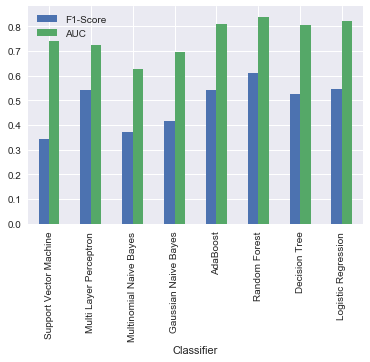

In [167]:
testing.drop(["Accuracy"], axis = 1).set_index("Classifier").plot.bar()